In [19]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Bidirectional
from keras.callbacks import ModelCheckpoint
import pickle
import numpy as np
from sklearn.metrics import r2_score

class Timeseries:
    def __init__ (self):

        self.scaler = MinMaxScaler()
        self.timestep = 100

        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(units=40,return_sequences=True,input_shape = (self.timestep,1))))
        self.model.add(Bidirectional(LSTM(units=20,return_sequences=True)))
        self.model.add(Bidirectional(LSTM(units=20,return_sequences=True)))
        self.model.add(Bidirectional(LSTM(units=20,return_sequences=False)))

        self.model.add(Dense(units = 20))
        self.model.add(Dense(units = 10))

        self.model.add(Dense(units = 5))
        self.model.add(Dense(units = 1))
        self.model.compile(optimizer= 'adam',loss = 'mean_squared_error')

        
    def make_supervised(self,data):
        timeseriesX = []
        timeseriesY = []

        
        for i in range(self.timestep,len(data)):
            timeseriesX.append(data[i-self.timestep:i,-1])
            timeseriesY.append(data[i,-1])
        timeseriesX = np.array(timeseriesX)
        timeseriesY = np.array(timeseriesY)

        print('Because',self.timestep,'observations per timestep was used,', timeseriesX.shape[0]-self.timestep,'trainable samples created from',timeseriesX.shape[0],'rows of the original data')
        print('apparent percentage of data used               : ',(timeseriesX.shape[0]-self.timestep)/timeseriesX.shape[0])
        print('apparent percentage of data lost in conversion : ',1-(timeseriesX.shape[0]-self.timestep)/timeseriesX.shape[0])
        return timeseriesX,timeseriesY

    def train_test_split(self,data):
        train = data[0:int(len(data)*0.7)]
        test =  data[1+ int(len(data)*0.7):]
        return train,test

    def reshape_for_LSTM(self,x,y):
        X_supervised = np.reshape(x,(x.shape[0],x.shape[1],1))
        Y_supervised = np.reshape(y,(-1,1))
        return X_supervised,Y_supervised


    def train(self,xtrain,ytrain,xvalid,yvalid):
        self.model.fit(x = xtrain,y = ytrain,epochs =5,
                 validation_data=(xtest,ytest),
                 callbacks= ModelCheckpoint('forex.hdf5',save_best_only=True,mode = 'min',verbose = 1))
ts = Timeseries()
data = pickle.load(open('EURUSD-2021-05-23.pickle','rb'))
data = np.reshape(data['open'].values,(-1,1))
data = ts.scaler.fit_transform(data)


#print(data['open'].values)
x,y = ts.make_supervised(data)
xtrain,xtest = ts.train_test_split(x)
ytrain,ytest = ts.train_test_split(y)


print(len(xtrain),len(xtest),len(ytrain),len(ytest))
print(x)
print(y)

xtrain,ytrain = ts.reshape_for_LSTM(xtrain,ytrain)
xtest,ytest = ts.reshape_for_LSTM(xtest,ytest)

print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)
ts.train(xtrain,ytrain,xtest,ytest)

xtrain_pred = ts.model.predict(xtrain)
xtest_pred = ts.model.predict(xtest)
print(r2_score(ytrain,xtrain_pred),r2_score(ytest,xtest_pred))

Because 100 observations per timestep was used, 8286 trainable samples created from 8386 rows of the original data
apparent percentage of data used               :  0.9880753637014071
apparent percentage of data lost in conversion :  0.011924636298592861
5870 2515 5870 2515
[[0.26735081 0.26812196 0.26978289 ... 0.29487484 0.29540871 0.29683236]
 [0.26812196 0.26978289 0.26847787 ... 0.29540871 0.29683236 0.29606122]
 [0.26978289 0.26847787 0.26675762 ... 0.29683236 0.29606122 0.29499347]
 ...
 [0.8852177  0.88385336 0.8899039  ... 0.91001305 0.90342864 0.89565785]
 [0.88385336 0.8899039  0.89067505 ... 0.90342864 0.89565785 0.90295409]
 [0.8899039  0.89067505 0.89109028 ... 0.89565785 0.90295409 0.90574208]]
[0.29606122 0.29499347 0.29558667 ... 0.90295409 0.90574208 0.90835212]
(5870, 100, 1) (5870, 1) (2515, 100, 1) (2515, 1)
Epoch 1/5
184/184 [==============================] - ETA: 0s - loss: 0.0058
Epoch 00001: val_loss improved from inf to 0.00025, saving model to forex.hdf5
184/

In [20]:
data = pickle.load(open('EURUSD-2021-05-23.pickle','rb'))


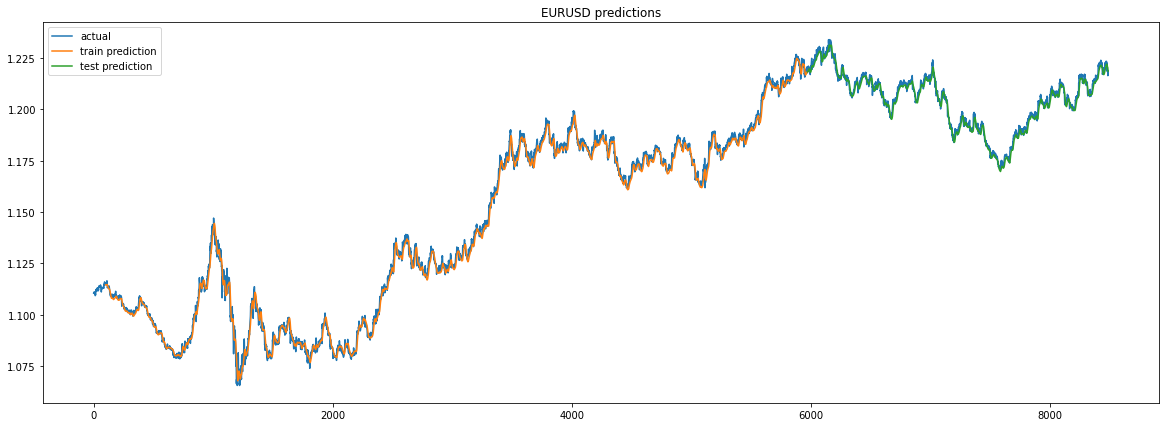

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,7))
plt.title('EURUSD predictions')

plt.plot(data['open'],label = 'actual')
plt.plot(range(ts.timestep,len(xtrain_pred)+ts.timestep),ts.scaler.inverse_transform(xtrain_pred),label = 'train prediction')
plt.plot(range(len(xtrain_pred)+ts.timestep,len(xtrain_pred)+ts.timestep+len(xtest_pred)),ts.scaler.inverse_transform(xtest_pred),label = 'test prediction')
plt.legend()
#plt.xlim([6120,6180])

In [25]:
ace = []
ps = []


def rolling_forecast(xtrain,ytrain,forcast_n_timeframes = 1):
    
    a = list(xtrain[1:])
    a.append(np.array([ytrain[0]]))
    a = np.array(a)
    a = np.reshape(a,(1,ts.timestep,1))
    p = ts.model.predict(a)
    ace.append(a)
    ps.append(p[0][0])
    print(round(len(ps)/forcast_n_timeframes*100,2),'%',end = '\r')
    #print(len(ps)== forcast_n_timeframes,forcast_n_timeframes,len(ps))
    if len(ps) == forcast_n_timeframes: 
        return ps
    else:
        p = np.reshape(p,(1,))
        a = a[0]
        #print(a.shape,p.shape)
        rolling_forecast(a,p,forcast_n_timeframes = forcast_n_timeframes)

    

In [26]:
ytest.shape

(2515, 1)

In [27]:
pres = rolling_forecast(xtrain[-1],ytrain[-1],forcast_n_timeframes = 1000)

In [28]:
np.reshape(np.array(ps),(1,-1)).shape

(1, 1000)

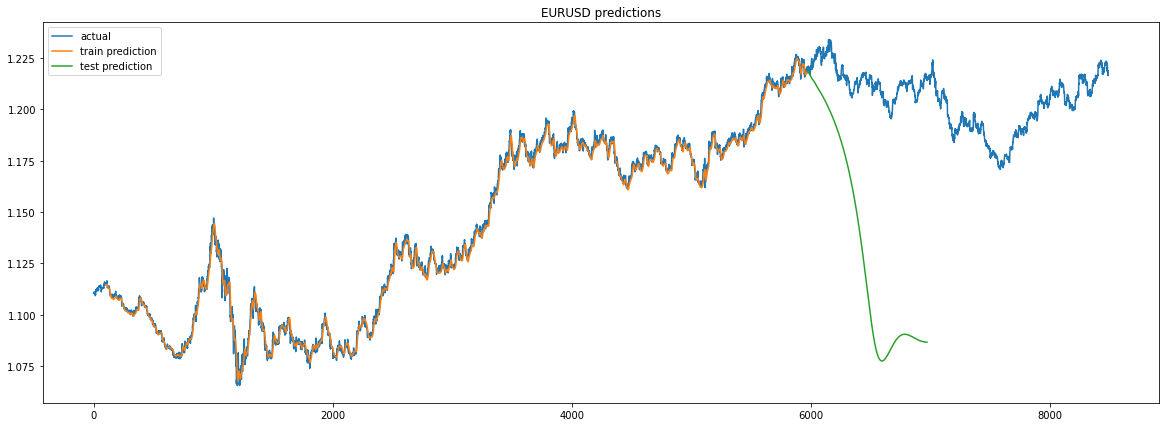

In [30]:
plt.figure(figsize = (20,7))
plt.title('EURUSD predictions')

plt.plot(data['open'],label = 'actual')
plt.plot(range(ts.timestep,len(xtrain_pred)+ts.timestep),ts.scaler.inverse_transform(xtrain_pred),label = 'train prediction')
plt.plot(range(len(xtrain_pred)+ts.timestep,len(xtrain_pred)+ts.timestep+len(ps)),ts.scaler.inverse_transform(np.reshape(np.array(ps),(-1,1))),label = 'test prediction')
plt.legend()
#plt.xlim([6120,6180])

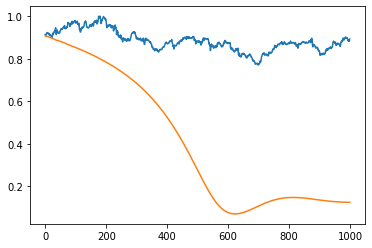

In [31]:
plt.plot(ytest[0:1000])
plt.plot(ps)

In [56]:
pred = ts.scaler.inverse_transform(np.reshape(np.array(ps),(len(ps),1)))[0:100]
true = ts.scaler.inverse_transform(ytest)[0:100]

for i in range(50):
    print(pred[i],true[i])

print('r2core',r2_score(true,pred))

[1.2183225] [1.21954]
[1.2182941] [1.21857]
[1.2182562] [1.21898]
[1.218208] [1.21943]
[1.2181554] [1.22023]
[1.2180952] [1.22082]
[1.2180318] [1.22111]
[1.2179691] [1.22092]
[1.2179061] [1.22044]
[1.2178404] [1.22049]
[1.2177707] [1.2207]
[1.2177005] [1.22054]
[1.217623] [1.22013]
[1.2175413] [1.21914]
[1.2174522] [1.21991]
[1.2173586] [1.21953]
[1.2172654] [1.21884]
[1.2171655] [1.21883]
[1.2170675] [1.21889]
[1.2169621] [1.2182]
[1.2168567] [1.21819]
[1.2167503] [1.21834]
[1.2166423] [1.21696]
[1.21653] [1.21883]
[1.2164094] [1.2204]
[1.2162848] [1.21923]
[1.2161582] [1.2205]
[1.2160317] [1.22087]
[1.2159102] [1.22126]
[1.2157934] [1.22101]
[1.2156855] [1.22234]
[1.2155693] [1.2225]
[1.2154648] [1.2231]
[1.2153604] [1.22392]
[1.2152681] [1.22488]
[1.2151797] [1.22136]
[1.2150891] [1.21948]
[1.215002] [1.22085]
[1.2149245] [1.22129]
[1.2148547] [1.22315]
[1.2147969] [1.22148]
[1.2147341] [1.22129]
[1.214698] [1.22063]
[1.2146443] [1.22085]
[1.2145708] [1.22068]
[1.2144938] [1.22136]


In [64]:
(true[1]-pred[1])/pred[1]

array([0.00022643])

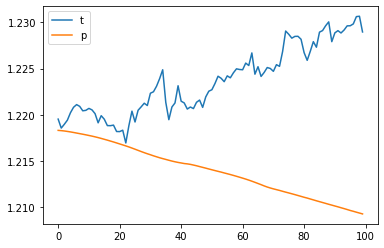

In [59]:
plt.plot(true,label = 't')
plt.plot(pred,label = 'p')
plt.legend()

In [46]:
ytest.shape

(2515, 1)

In [48]:
np.array(ps).shape

(1000,)

In [32]:
xtrain[-1]

array([[0.9469688 ],
       [0.94370625],
       [0.95141772],
       [0.95248547],
       [0.95675644],
       [0.95373117],
       [0.95432436],
       [0.95693439],
       [0.9566378 ],
       [0.95331593],
       [0.94934156],
       [0.9504093 ],
       [0.94441808],
       [0.94435876],
       [0.9410369 ],
       [0.94240123],
       [0.94827382],
       [0.94501127],
       [0.95129909],
       [0.94607901],
       [0.94904496],
       [0.94987543],
       [0.94922292],
       [0.94578242],
       [0.93913869],
       [0.93759639],
       [0.93783367],
       [0.93860482],
       [0.94192668],
       [0.94186736],
       [0.94424012],
       [0.92668169],
       [0.93308815],
       [0.92377506],
       [0.92816467],
       [0.92187685],
       [0.91054692],
       [0.90787757],
       [0.91161466],
       [0.91167398],
       [0.91618223],
       [0.90247953],
       [0.92703761],
       [0.90224226],
       [0.88581089],
       [0.89447147],
       [0.89530193],
       [0.911

In [33]:
ace

[array([[[0.94370625],
         [0.95141772],
         [0.95248547],
         [0.95675644],
         [0.95373117],
         [0.95432436],
         [0.95693439],
         [0.9566378 ],
         [0.95331593],
         [0.94934156],
         [0.9504093 ],
         [0.94441808],
         [0.94435876],
         [0.9410369 ],
         [0.94240123],
         [0.94827382],
         [0.94501127],
         [0.95129909],
         [0.94607901],
         [0.94904496],
         [0.94987543],
         [0.94922292],
         [0.94578242],
         [0.93913869],
         [0.93759639],
         [0.93783367],
         [0.93860482],
         [0.94192668],
         [0.94186736],
         [0.94424012],
         [0.92668169],
         [0.93308815],
         [0.92377506],
         [0.92816467],
         [0.92187685],
         [0.91054692],
         [0.90787757],
         [0.91161466],
         [0.91167398],
         [0.91618223],
         [0.90247953],
         [0.92703761],
         [0.90224226],
         [0

In [34]:
ps

[0.9068843,
 0.9067154,
 0.906491,
 0.9062045,
 0.905893,
 0.90553546,
 0.9051592,
 0.90478724,
 0.9044137,
 0.9040242,
 0.9036107,
 0.9031947,
 0.90273446,
 0.9022506,
 0.90172106,
 0.90116596,
 0.90061307,
 0.90002054,
 0.8994389,
 0.8988145,
 0.898189,
 0.8975579,
 0.8969171,
 0.89625067,
 0.8955362,
 0.8947963,
 0.89404476,
 0.89329475,
 0.8925744,
 0.89188176,
 0.8912415,
 0.8905521,
 0.8899326,
 0.88931304,
 0.8887659,
 0.88824147,
 0.88770336,
 0.8871864,
 0.8867271,
 0.8863135,
 0.8859704,
 0.88559765,
 0.8853832,
 0.88506514,
 0.88462895,
 0.8841724,
 0.88365096,
 0.8831458,
 0.88264465,
 0.88210815,
 0.88159966,
 0.8810888,
 0.8805925,
 0.88010776,
 0.8795682,
 0.8790545,
 0.8785307,
 0.87798274,
 0.8774119,
 0.87682885,
 0.8762371,
 0.8756202,
 0.8749663,
 0.87427205,
 0.87354594,
 0.8727946,
 0.87204313,
 0.871244,
 0.8705282,
 0.8699079,
 0.8693515,
 0.868849,
 0.8683467,
 0.86778647,
 0.8672446,
 0.86673146,
 0.86619514,
 0.8656517,
 0.86508775,
 0.8645229,
 0.8639505,
 0

In [35]:
ytrain[-1]

array([0.90603868])

In [ ]:
b = []
for i in range(ytest.shape[0]):
    b.append(rolling_forecast())

In [ ]:
xtrain[-1]

In [15]:
ytrain[-2]

array([0.91025033])

In [26]:
a = np.random.random([1,3])
a

array([[0.54575228, 0.24980782, 0.18022472]])

In [27]:
a[0][1] = 3

AttributeError: 'numpy.ndarray' object has no attribute 'extend'

In [85]:
a = list(xtrain[-1][1:])
a.append(np.array([ytrain[-1][0]]))
a = np.array(a)
a = np.reshape(a,(1,60,1))
a,a.shape

(array([[[0.94186736],
         [0.94424012],
         [0.92668169],
         [0.93308815],
         [0.92377506],
         [0.92816467],
         [0.92187685],
         [0.91054692],
         [0.90787757],
         [0.91161466],
         [0.91167398],
         [0.91618223],
         [0.90247953],
         [0.92703761],
         [0.90224226],
         [0.88581089],
         [0.89447147],
         [0.89530193],
         [0.91161466],
         [0.92211413],
         [0.92341915],
         [0.93534227],
         [0.93830822],
         [0.94299442],
         [0.94560446],
         [0.93581682],
         [0.94257919],
         [0.94097758],
         [0.93747776],
         [0.93516431],
         [0.93540159],
         [0.93611342],
         [0.93409657],
         [0.93071539],
         [0.92780876],
         [0.92697829],
         [0.92674101],
         [0.92952901],
         [0.92116503],
         [0.93457112],
         [0.94269783],
         [0.94026575],
         [0.9348084 ],
         [0

In [77]:
ytrain[-1
      
      ][0]

0.9069877802823578

In [84]:
np.reshape(a,(1,60,1)).shape

(1, 60, 1)